In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import importlib
sys.path.insert(0, '/home/tchari/monod/src/')

In [3]:
import monod
#importlib.reload(monod)
from monod import preprocess, extract_data, cme_toolbox, inference, analysis, mminference

In [4]:
import pandas as pd
import numpy as np
import loompy as lp
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
import scipy.stats
import os

In [5]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [6]:
meta_path = "/home/tchari/metadata/"
meta = pd.read_csv(meta_path+'norman_GSE133344_filtered_cell_identities.csv')

#'guide_identity'

In [7]:
ids = list(meta['guide_identity'].value_counts().index)
counts = list(meta['guide_identity'].value_counts())

saveCounts = pd.DataFrame()
saveCounts['guide_identity'] = ids
saveCounts['cells'] = counts

In [8]:
filt_ids = list(set(saveCounts['guide_identity'][saveCounts['cells'] >  1000]).intersection(set(saveCounts['guide_identity'][saveCounts['cells'] <  1170])))
len(filt_ids)

1

In [9]:
dataset_meta = ['allcrispr']
print('dataset_meta: ', dataset_meta)
print()

subcluster_names = [[i] for i in filt_ids]

sub_names_only = ['_'.join(n) for n in subcluster_names]

cluster_names = []
dataset_names = ['norman_'+dataset_meta[0]+'_'+y  for y in sub_names_only]   #To save
print('dataset_names: ', dataset_names)
print('len(dataset_names): ',len(dataset_names))
print()

raw_data_locations = [dataset_meta[0] for y in sub_names_only]
transcriptome_filepath = '/home/tchari/perturbCME/notebooks/gg_200525_genome_polyA_cum_3'

spliced_layer = 'spliced'
unspliced_layer = 'unspliced'
gene_attr = 'gene_name'
cell_attr = 'barcode'

attribute_names=[(unspliced_layer,spliced_layer),gene_attr,cell_attr]

loom_filepaths = ['/home/tchari/counts/norman_crispr/loom/'+x+'.loom' for x in raw_data_locations] 
print('loom_filepaths: ',loom_filepaths)

n_datasets = len(loom_filepaths)

dataset_meta:  ['allcrispr']

dataset_names:  ['norman_allcrispr_TBX3_TBX2__TBX3_TBX2']
len(dataset_names):  1

loom_filepaths:  ['/home/tchari/counts/norman_crispr/loom/allcrispr.loom']


Dataset allcrispr. 
	116844 barcodes in loom, 94649 pass filter. TTGAACGAGACTCGGA-2CGTTGGGGTGTTTGTG-7GAACCTAAGTGTTAGA-6CCTTCCCTCCGTCATC-4TCAATCTGTCTTTCAT-2TCCCGATGTCTCTTAT-8AAACCTGTCCAGAAGG-2CTGCCTAGTTCCACAA-4GAACCTATCCAGAAGG-3AAGCCGCTCACTCCTG-5TTCTTAGCATGGGAAC-7GACGGCTTCGTCACGG-1TGCGGGTCATTCACTT-8GGACAAGGTAGGGACT-5CGCGGTAGTGAGTATA-8CTGATAGTCACAGGCC-3ACGGAGACAATGGATA-5CATGGCGGTATATGAG-5ACATGGTGTCCAGTAT-5GACCAATTCAACACAC-4AACACGTCATTCTTAC-4CTAGCCTTCAACACGT-4GAACCTAAGCTCTCGG-5GCGCCAAGTGTGACCC-6CGCGGTAAGATAGTCA-1CGTTAGAGTTCGTGAT-8TGCTACCAGCGATTCT-5CGGTTAATCTTCTGGC-5AGACGTTGTCTAGCGC-2TTGGAACTCAAGCCTA-7TCAATCTCATTGAGCT-5CTAACTTCAGACGCTC-5CAACCTCAGGCGACAT-5AGACGTTGTCAAACTC-5CCAATCCAGTCAAGCG-5TACGGATTCGGATGGA-5ACGCCAGTCATCTGCC-5CAGCTGGGTTCGTTGA-4TCGGGACCAATAGCGG-1AACCATGTCTCTGAGA-5ATTATCCAGCGTGTCC-5TATCAGGCAAGCGATG-5AACCGCGCATTGGTAC-3GCGCAGTGTCCAAGTT-5TTGGAACCAGGGAGAG-7ATGCGATAGTACGCGA-5GCGCCAACACACCGCA-8AACGTTGAGCGTAGTG-1CAGCATATCTCAACTT-2TCCCGATGTAAACGCG-5ATGAGGGCATTGGCGC-2TAGGCATCACAGAGGT-

	['TBX3_TBX2__TBX3_TBX2']: 1167 cells in annotations. 1167 in loom. 1028 pass filter.
mkdir: cannot create directory ‘./figs’: File exists


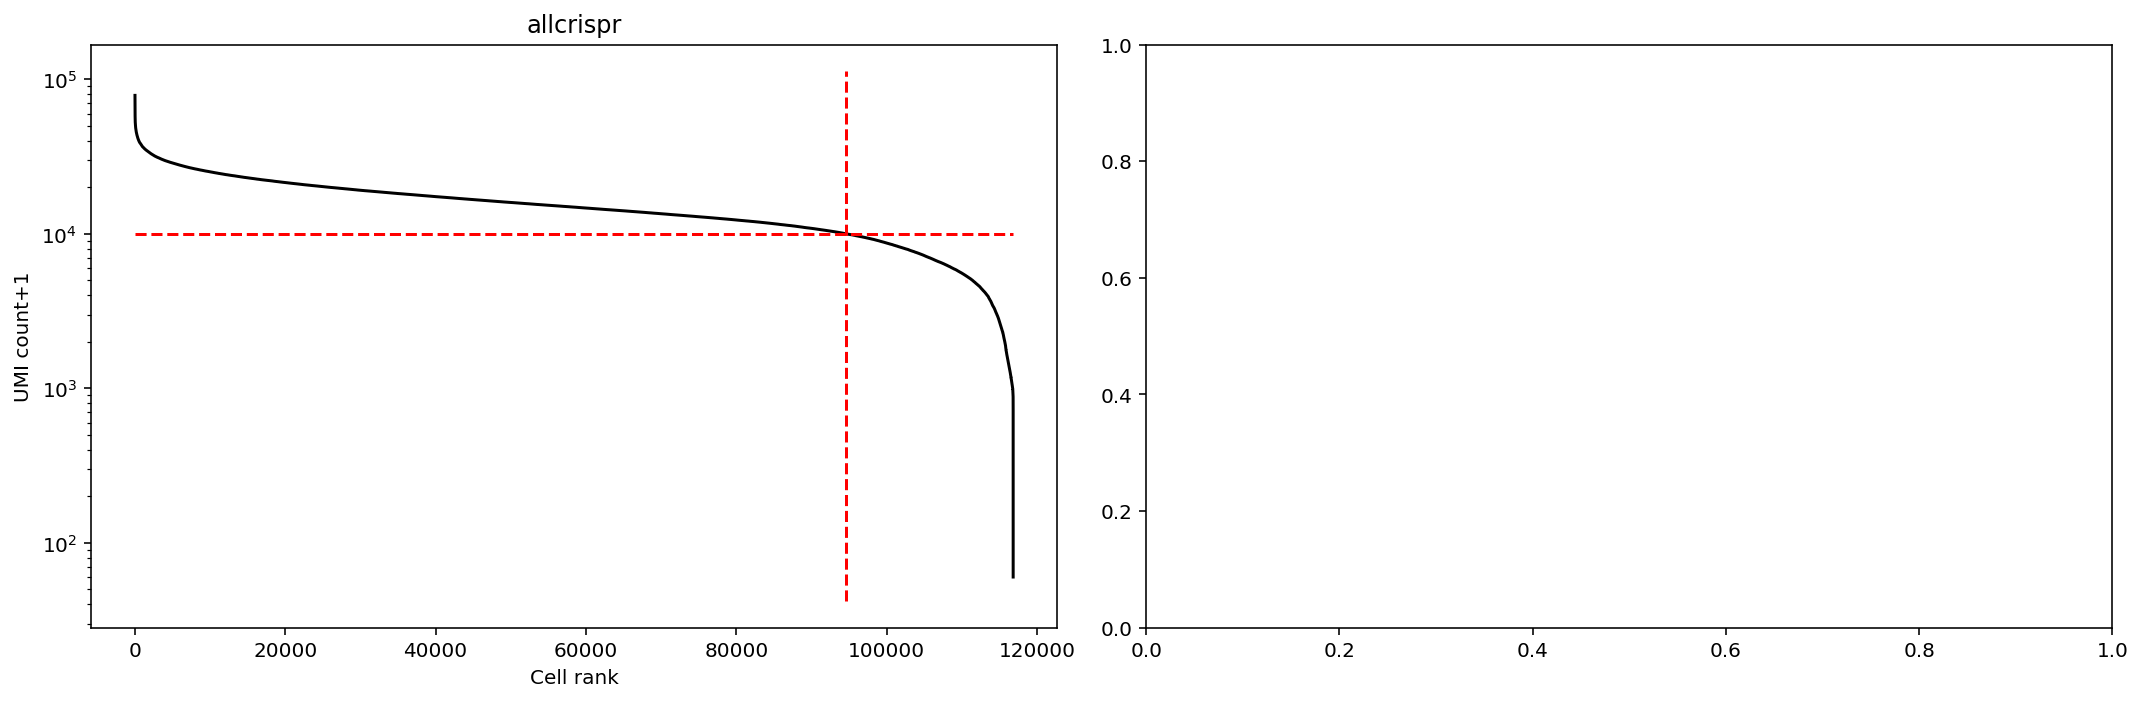

In [10]:
cf = []
thr_lb = [1e4]*len(dataset_meta)*2

fig1,ax1 = plt.subplots(1,len(dataset_meta)*2,figsize=(15,5))

for k in range(len(dataset_meta)):
    filename = loom_filepaths[len(subcluster_names)*k]
    dataset_name = raw_data_locations[len(subcluster_names)*k]
    
    with lp.connect(filename,mode='r') as ds:
        S = ds.layers[spliced_layer][:]
        U = ds.layers[unspliced_layer][:]
        gene_names = ds.ra[gene_attr]
        bcs = ds.ca[cell_attr]
        n_cells = S.shape[1]
        monod.preprocess.knee_plot(S+U,ax1[k],viz=True,thr=thr_lb[k])
        cf_ = ((S+U).sum(0)>thr_lb[k])
        
        n_annot_bcs = meta['cell_barcode'].sum()
        annot_bcs_in_loom = meta['cell_barcode'].isin(bcs).sum()
        annot_bcs_in_filt_loom = meta['cell_barcode'].isin(bcs[cf_]).sum()
        print(f'Dataset {dataset_name}. \n\t{len(bcs)} barcodes in loom, {cf_.sum()} pass filter. {n_annot_bcs} in annotations; of these, {annot_bcs_in_loom} in loom and {annot_bcs_in_filt_loom} in filtered loom.')
        
        #if k==0:
        for subcluster in subcluster_names:
            annot_bcs = meta[(meta['guide_identity'].isin(subcluster))]['cell_barcode']
            cf.append(np.isin(bcs,annot_bcs) & cf_)
            print(f'\t{subcluster}: {len(annot_bcs)} cells in annotations. {np.isin(bcs,annot_bcs).sum()} in loom. {cf[-1].sum()} pass filter.')



    ax1[k].set_title(dataset_name)
    
!mkdir ./figs    
fig_dir = './figs/'
fig_string = fig_dir + 'kneeplots_top_norman_forMM.png'
fig1.tight_layout()
plt.savefig(fig_string,dpi=450)

## **Gene Filtering**

In [11]:
import logging, sys
logging.basicConfig(stream=sys.stdout)
log = logging.getLogger()
log.setLevel(logging.INFO)

In [12]:
# !mkdir ./fits

In [13]:
# dir_string,dataset_strings = monod.preprocess.construct_batch(loom_filepaths, \
#                                              transcriptome_filepath, \
#                                              dataset_names, \
#                                              attribute_names=attribute_names,\
#                                              batch_location='./fits',meta='norman_crispr_test_MM',batch_id=1,\
#                                              n_genes=3000,exp_filter_threshold=None,cf=cf)

In [14]:
dir_string = './fits/gg_230327_025_norman_crispr_test_MM_1'

In [15]:
dataset_strings = [ dir_string+'/'+item for item in os.listdir(dir_string) if os.path.isdir(os.path.join(dir_string, item)) ]


In [16]:
dataset_strings = [i for i in dataset_strings if 'diagnostic_figures' not in i]
print(dataset_strings)

['./fits/gg_230327_025_norman_crispr_test_MM_1/norman_allcrispr_TBX3_TBX2__TBX3_TBX2']


## **Test Mixture Model Inference**

In [17]:
#Define bounds, from 20220930_normanfit_monod.ipynb
phys_lb = [-2.0, -1.8, -1.8 ] #-1.0, -1.8, -1.8
phys_ub = [4.2, 2.5, 2.5] #4.2, 2.5, 3.5
samp_lb = [-7.157894736842105, -1.525] #-7.5, -2
samp_ub = [-7.157894736842105, -1.525] #-5.5, 0
# gridsize = [5,6]
gridsize = [1,1]


In [18]:
k=2
epochs=1

INFO:root:Directory ./fits/gg_230327_025_norman_crispr_test_MM_1/norman_allcrispr_TBX3_TBX2__TBX3_TBX2/Bursty_Poisson_1x1 already exists.
INFO:root:Global inference parameters stored to ./fits/gg_230327_025_norman_crispr_test_MM_1/norman_allcrispr_TBX3_TBX2__TBX3_TBX2/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: norman_allcrispr_TBX3_TBX2__TBX3_TBX2
INFO:root:36601 features observed, 36169 match genome annotations. 35727 were unique.
INFO:root:Gene list extracted from ./fits/gg_230327_025_norman_crispr_test_MM_1/genes.csv.
INFO:root:Directory ./fits/gg_230327_025_norman_crispr_test_MM_1/norman_allcrispr_TBX3_TBX2__TBX3_TBX2/diagnostic_figures already exists.
INFO:root:Search data stored to ./fits/gg_230327_025_norman_crispr_test_MM_1/norman_allcrispr_TBX3_TBX2__TBX3_TBX2/raw.sd.


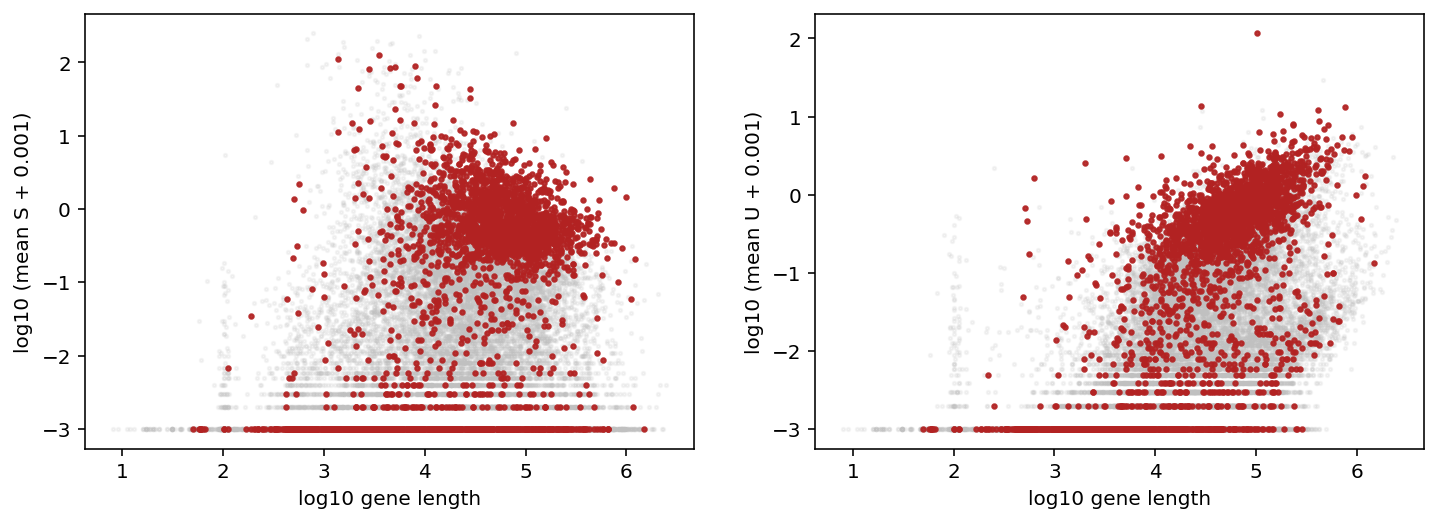

In [19]:
result_strings = []
for i in range(0,1): #n_datasets
    
    fitmodel = monod.cme_toolbox.CMEModel('Bursty','Poisson')
    
    inference_parameters = monod.mminference.InferenceParameters(phys_lb,phys_ub,samp_lb,samp_ub,gridsize,\
                dataset_strings[i],fitmodel,k=k,epochs=epochs,use_lengths = True,
                gradient_params = {'max_iterations':20,'init_pattern':'moments','num_restarts':5})
    
    search_data = monod.extract_data.extract_data(loom_filepaths[i], transcriptome_filepath, dataset_names[i],
                dataset_strings[i], dir_string, dataset_attr_names=attribute_names,cf=cf[i])
    
#     full_result_string = inference_parameters.fit_all_grid_points(30,search_data)

#     result_strings.append(full_result_string)

In [20]:
inference_parameters.fit_all_grid_points(30,search_data)

INFO:root:Starting non-parallelized grid scan.
INFO:root:M Step Initial Run: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [17:26<00:00, 523.34s/it]


INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/1: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [11:26<00:00, 343.22s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.57824334 0.42175666]
logL:  -4321.050546355649
INFO:root:Non-parallelized grid scan complete.


In [21]:
import pickle 
with open("/home/tchari/perturbCME/notebooks/fits/gg_230327_025_norman_crispr_test_MM_1/norman_allcrispr_TBX3_TBX2__TBX3_TBX2/Bursty_Poisson_1x1/grid_point_0.gp", "rb") as ipfs:
    grid_point_results = pickle.load(ipfs)
    

In [35]:
grid_point_results.weights


array([0.57824334, 0.42175666])

In [19]:
l1=[1,2,3]
l2 = ['1','2','3']
d = dict(zip(l1,l2))

In [84]:
weights = np.ones(k)/k

In [86]:
np.log(weights)[None,:]

array([[-1.60943791, -1.60943791, -1.60943791, -1.60943791, -1.60943791]])

In [88]:
test = np.zeros((search_data.n_cells,k))
test.shape

(1028, 5)

In [89]:
test[:,0] = Q[tuple(x.T)]

In [91]:
test += np.log(weights)[None,:]

In [93]:
np.log(weights)[None,:]

array([[-1.60943791, -1.60943791, -1.60943791, -1.60943791, -1.60943791]])

In [92]:
test

array([[-1.58959722, -1.60943791, -1.60943791, -1.60943791, -1.60943791],
       [-1.58959722, -1.60943791, -1.60943791, -1.60943791, -1.60943791],
       [-0.67426778, -1.60943791, -1.60943791, -1.60943791, -1.60943791],
       ...,
       [-0.67426778, -1.60943791, -1.60943791, -1.60943791, -1.60943791],
       [-1.58959722, -1.60943791, -1.60943791, -1.60943791, -1.60943791],
       [-0.67426778, -1.60943791, -1.60943791, -1.60943791, -1.60943791]])

In [105]:
x,f = search_data.hist[2]

In [106]:
x.shape

(10, 2)

In [109]:
tuple(x.T)

(array([0, 0, 0, 0, 1, 1, 1, 2, 2, 2]), array([0, 1, 2, 3, 0, 1, 2, 0, 1, 2]))

In [94]:
S = search_data.layers[1][2]
U = search_data.layers[0][2]

In [95]:
S

array([0, 0, 1, ..., 1, 0, 1])

In [96]:
U

array([0, 0, 0, ..., 0, 0, 0])

In [110]:
x = np.array([U,S])
x

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 1, 0, 1]])

In [111]:
x.shape

(2, 1028)

In [112]:
tuple(x)

(array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 1, ..., 1, 0, 1]))

In [ ]:
result_strings = [i+'/Bursty_Poisson_1x1/grid_scan_results.res' for i in dataset_strings]
print(result_strings[0])

In [25]:
weights = np.ones(k)/k
weights.shape

(5,)

In [74]:
Q = np.random.uniform(0,1,size=(10, k))
Q.shape

(10, 5)

In [78]:
Q[tuple(x.T)]

array([0.01984069, 0.01984069, 0.93517013, ..., 0.93517013, 0.01984069,
       0.93517013])

In [76]:
Q

array([[0.01984069, 0.93517013, 0.56235178, 0.44557665, 0.06712787],
       [0.82951759, 0.18943135, 0.39075861, 0.81089811, 0.177445  ],
       [0.05132   , 0.11823884, 0.4465261 , 0.30344335, 0.42533533],
       [0.62017761, 0.05873446, 0.46374256, 0.47907979, 0.45781741],
       [0.65207384, 0.25063437, 0.60955709, 0.81564975, 0.87962711],
       [0.21722224, 0.68801618, 0.19931873, 0.57293212, 0.61978727],
       [0.63347979, 0.55575639, 0.82499143, 0.26820907, 0.32326552],
       [0.15853788, 0.43783169, 0.32766601, 0.26241691, 0.06326963],
       [0.14958338, 0.87861033, 0.39106511, 0.84854791, 0.10301592],
       [0.41541721, 0.09213956, 0.15725568, 0.43530904, 0.95243721]])

In [24]:
max_ks = np.argmax(Q, axis=1) 

In [27]:
obs_inds = max_ks == 4

In [32]:
len(search_data.gene_names)

3000

In [37]:
layers  = search_data.layers

In [39]:
l = [layers[0,:,:],layers[1,:,:]]

In [47]:
np.amax(l, axis=2) + np.asarray([10] * len(l))[:, None]

array([[10, 14, 12, ..., 11, 10, 11],
       [10, 22, 13, ..., 10, 10, 10]])

In [46]:
np.amax(l, axis=2).shape

(2, 3000)

In [37]:
Q2 = Q*weights
Q2

array([[0.04402882, 0.18446542, 0.13651583, 0.1215321 , 0.10488286],
       [0.09570316, 0.17442751, 0.11163041, 0.08312561, 0.1689032 ],
       [0.07526832, 0.07392176, 0.11254892, 0.1854725 , 0.19106196],
       [0.15986042, 0.05546198, 0.0547946 , 0.01219751, 0.18167647],
       [0.14153915, 0.11921324, 0.12516103, 0.19923663, 0.03524695],
       [0.18627848, 0.1894013 , 0.03879008, 0.0003504 , 0.06721489],
       [0.14595611, 0.16658483, 0.06063392, 0.07870247, 0.09775323],
       [0.0291216 , 0.09104225, 0.19059344, 0.00348123, 0.07835434],
       [0.17492596, 0.01420693, 0.13037754, 0.14814673, 0.02355638],
       [0.13010203, 0.02301097, 0.02158269, 0.1679716 , 0.00532796]])

In [38]:
Q=Q/Q.sum(axis=(-1),keepdims=True)
Q

array([[0.07444531, 0.31189992, 0.23082524, 0.20549029, 0.17733923],
       [0.1510014 , 0.27521346, 0.17613158, 0.13115642, 0.26649715],
       [0.11792487, 0.11581519, 0.17633339, 0.2905847 , 0.29934185],
       [0.34453346, 0.11953245, 0.11809411, 0.02628825, 0.39155173],
       [0.22814286, 0.19215638, 0.20174345, 0.32114377, 0.05681353],
       [0.38644171, 0.3929201 , 0.08047147, 0.00072692, 0.1394398 ],
       [0.26555312, 0.30308508, 0.11031759, 0.14319158, 0.17785262],
       [0.07417761, 0.23189992, 0.48547353, 0.00886727, 0.19958166],
       [0.35610981, 0.0289221 , 0.26541928, 0.30159334, 0.04795547],
       [0.37386152, 0.06612437, 0.06202008, 0.4826836 , 0.01531043]])

In [32]:
d = [([1,1],2,3),(4,5,6)]

In [33]:
a,b,c = d[0]

In [35]:
a

[1, 1]